<a href="https://colab.research.google.com/github/coltbk/AMe_508_Final_Project/blob/dev/AME508_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict


**Define ODE System**

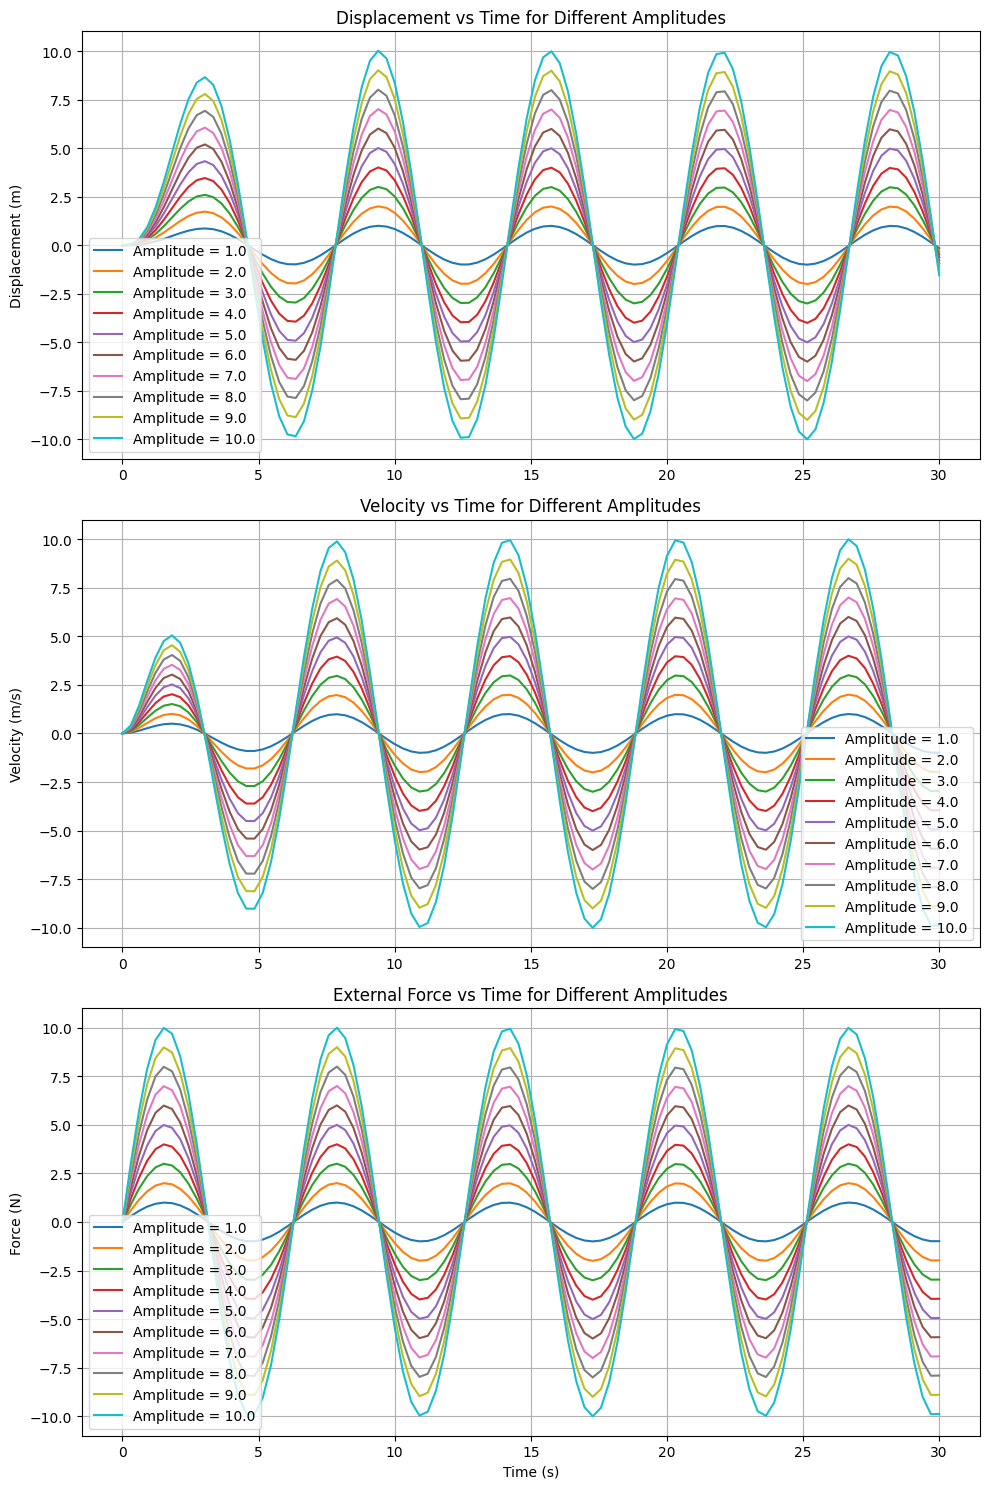

In [17]:

def spring_mass_damper_with_force(t_span, initial_conditions, parameters, force_func):

    """
    Propagates the equations of motion for a spring-mass-damper system with an external force.


    Parameters:

    - t_span: Tuple of (t_start, t_end) for the time span of the simulation.

    - initial_conditions: List or array of initial conditions [x0, v0].

    - parameters: Dictionary containing 'k' (spring constant), 'c' (damping coefficient), and 'm' (mass).

    - force_func: Function that takes time as input and returns the force applied to the mass.



    Returns:

    - t: Time points at which the solution is computed.

    - z: Solution array with displacement and velocity.

    """



    k = parameters['k'] # Spring constant (N/m)
    c = parameters['c'] # Damping coefficient (N*s/m)
    m = parameters['m'] # Mass (kg)
    amplitude = parameters['amplitude']
    period = parameters['period']
    phase_shift = parameters['phase_shift']
    vertical_shift = parameters['vertical_shift']



    # Define the system of ODEs
    def equations_of_motion(t, z, amplitude=amplitude, period=period, phase_shift=phase_shift, vertical_shift=vertical_shift):

        x, v = z
        F_ext = force_func(t, amplitude, period, phase_shift, vertical_shift)  # Get the external force at time t
        dxdt = v
        dvdt = (F_ext - k * x - c * v) / m  # Include the external force in the equation

        return [dxdt, dvdt]

    # Solve the ODEs, the number of t_evla must match number of sensors
    solution = solve_ivp(equations_of_motion, t_span, initial_conditions, t_eval=np.linspace(t_span[0], t_span[1], 100))

    # here we have to resturn solution.y according to sacipy convention, but elsewhere the state vector is z
    return solution.t, solution.y


# Force function

def external_force(t, amplitude=1.0, period=1.0, phase_shift=0.0, vertical_shift=0.0):

    return amplitude * np.sin(period * (t + phase_shift)) + vertical_shift  # Example: sinusoidal force



# Parameters
parameters = {
    'k': 1.0,  # Spring constant (N/m)
    'c': 1.0,  # Damping coefficient (N*s/m)
    'm': 1.0,   # Mass (kg)
    'amplitude': 1.0,
    'period': 1.0,
    'phase_shift': 0.0,
    'vertical_shift': 0.0
}


# Initial conditions: [initial displacement, initial velocity]
initial_conditions = [0.0, 0.0]  # x0 = 0 m, v0 = 0 m/s



# Time span for the simulation
t_span = (0.0, 30.0)  # From 0 to 30 seconds


# Run the simulation
t, z = spring_mass_damper_with_force(t_span, initial_conditions, parameters, external_force)


# # Plot the results
# plt.figure(figsize=(10, 8))



# # Plot Displacement
# plt.subplot(3, 1, 1)
# plt.plot(t, z[0], label='Displacement (x)', color='blue')
# plt.ylabel('Displacement (m)')
# plt.legend()
# plt.grid()



# # Plot Velocity
# plt.subplot(3, 1, 2)
# plt.plot(t, z[1], label='Velocity (v)', color='orange')
# plt.ylabel('Velocity (m/s)')
# plt.legend()
# plt.grid()


# # Plot External Force
# t_force = np.linspace(t_span[0], t_span[1], 100)
# force_values = external_force(t_force)
# plt.subplot(3, 1, 3)
# plt.plot(t_force, force_values, label='External Force (F)', color='green')
# plt.ylabel('Force (N)')
# plt.xlabel('Time (s)')
# plt.legend()
# plt.grid()


# plt.tight_layout()
# plt.show()


#############################################
# Vary the amplitude of the forcing function
#############################################

amplitudes = np.linspace(1, 10, 10)  # Amplitudes from 1 to 10

plt.figure(figsize=(10, 15))


# Prepare lists to store results for plotting
all_displacements = []
all_velocities = []
all_forces = []
t_values = []


for amplitude in amplitudes:

    parameters['amplitude'] = amplitude

    # Run the simulation
    t, z = spring_mass_damper_with_force(t_span, initial_conditions, parameters, external_force)

    # Store results
    all_displacements.append(z[0])
    all_velocities.append(z[1])
    t_values.append(t)


# Plot Displacements
plt.subplot(3, 1, 1)
for i, amplitude in enumerate(amplitudes):
  plt.plot(t_values[i], all_displacements[i], label=f'Amplitude = {amplitude}')
plt.ylabel('Displacement (m)')
plt.title('Displacement vs Time for Different Amplitudes')
plt.legend()
plt.grid()



# Plot Velocities
plt.subplot(3, 1, 2)
for i, amplitude in enumerate(amplitudes):
  plt.plot(t_values[i], all_velocities[i], label=f'Amplitude = {amplitude}')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs Time for Different Amplitudes')
plt.legend()
plt.grid()


# Plot External Forces
plt.subplot(3, 1, 3)
for amplitude in amplitudes:
  t_force = np.linspace(t_span[0], t_span[1], 100)
  force_values = external_force(t_force, amplitude)
  plt.plot(t_force, force_values, label=f'Amplitude = {amplitude}')
plt.ylabel('Force (N)')
plt.xlabel('Time (s)')
plt.title('External Force vs Time for Different Amplitudes')
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()

**Generate Training Dataset**

In [18]:
# Define parameter sweep to generate functino space
num_amplitudes = 10
amplitude_min = 1.0
amplitude_max = 10.0
amplitudes = np.linspace(amplitude_min, amplitude_max, num_amplitudes)

# Generate normalized random sensor locations
num_sensors = 100
sensor_min = 0.0
sensor_max = 1.0
sensor_locations = np.random.uniform(sensor_min, sensor_max, num_sensors)

# Prepare lists to store the training data
branch_data = []  # Initial state vector (z0)
trunk_data = []  # Sensor locations (t)
output_data = [] # Displacement (x) at sensor locations and times

# Loop through different amplitudes and sensor locations
# Parameters
parameters = {
    'k': 1.0,  # Spring constant (N/m)
    'c': 1.0,  # Damping coefficient (N*s/m)
    'm': 1.0,   # Mass (kg)
    'amplitude': 1.0,
    'period': 1.0,
    'phase_shift': 0.0,
    'vertical_shift': 0.0
}
for amplitude in amplitudes:
    parameters['amplitude'] = amplitude  # Update the amplitude in the parameters dictionary

    # Get the solution
    t, z = spring_mass_damper_with_force(t_span, initial_conditions, parameters, external_force)

    # Create forcing function data for branch net
    num_input_function_points = 50
    t_force = np.linspace(t_span[0], t_span[1], num_input_function_points)
    force_values = external_force(t_force, amplitude)

    # u(t,x) is approximated by displacement at specific time steps and sensor locations

    # Extract displacement (u) at sensor locations for all time steps in 't'
    cubic_spline = CubicSpline(t, z[0])  # Using displacement (z[0]) as the dependent variable
    sensor_times = sensor_locations * (t_span[1] - t_span[0]) + t_span[0]  # Convert sensor locations to time values
    displacements_at_sensors = cubic_spline(sensor_times)


    # Add data to the lists: initial_conditions, sensor_locations, displacement at sensors
    branch_data.extend([force_values] * len(displacements_at_sensors))  # Initial conditions are constant for this amplitude
    trunk_data.extend(sensor_locations)
    output_data.extend(displacements_at_sensors)



# Convert data to PyTorch tensors and add extra dimension to make dimensions match
train_branch_data = torch.tensor(branch_data, dtype=torch.float32)
train_trunk_data = torch.tensor(trunk_data, dtype=torch.float32).unsqueeze(-1)
train_output_data = torch.tensor(output_data, dtype=torch.float32).unsqueeze(-1)

print(f"Branch Data Shape: {train_branch_data.shape}")
print(f"Trunk Data Shape: {train_trunk_data.shape}")
print(f"Output Data Shape: {train_output_data.shape}")
print(f"Branch Data[0]: {branch_data[0]}")
print(f"Trunk Data[0]: {trunk_data[:num_sensors]}")
print(f"Output Data[0]: {output_data[:num_sensors]}")

Branch Data Shape: torch.Size([1000, 50])
Trunk Data Shape: torch.Size([1000, 1])
Output Data Shape: torch.Size([1000, 1])
Branch Data[0]: [ 0.          0.57470604  0.94063279  0.96484631  0.63855032  0.08028167
 -0.50715171 -0.91034694 -0.9828312  -0.6982724  -0.16004509  0.43632343
  0.8741843   0.99447137  0.75348673  0.23877532 -0.36267843 -0.8323783
 -0.99969166 -0.80383688 -0.31596412  0.28669214  0.78519883  0.99845837
  0.8489978   0.39111319 -0.20885508 -0.73295045 -0.99077947 -0.88867797
 -0.4637374   0.12966975  0.67597047  0.97670452  0.92262121  0.53336793
 -0.04964733 -0.61462671 -0.9563244  -0.95060842 -0.59955527 -0.03069559
  0.54931519  0.92977066  0.97245891  0.66187214  0.11084036 -0.48045753
 -0.89721473 -0.98803162]
Trunk Data[0]: [0.852917152299978, 0.14251200019599952, 0.6761991134926852, 0.4118185755186854, 0.16415036780592407, 0.46385116458362585, 0.5045853363110858, 0.8453038632458104, 0.6596640089287099, 0.8039356644958696, 0.4999305005570551, 0.597648616915

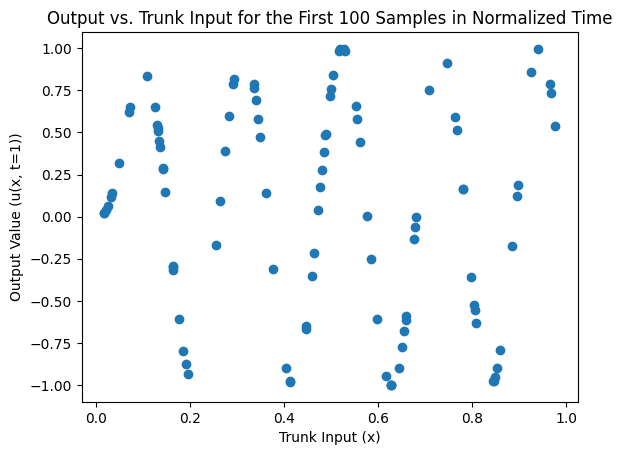

In [19]:
# Get the data to plot for the first u(0)
input_values = train_branch_data[0].ravel()
trunk_values = train_trunk_data[:num_sensors].ravel()
output_values = train_output_data[:num_sensors]

# Create the plot
plt.scatter(trunk_values, output_values, marker='o')

# Add labels and title
plt.xlabel('Trunk Input (x)')
plt.ylabel('Output Value (u(x, t=1))')
plt.title('Output vs. Trunk Input for the First 100 Samples in Normalized Time')

# Display the plot
plt.show()

Notes

- ensure evaluation nodes are selected randomly for each case


**MLP Setup**

In [20]:
class MLP(nn.Module):

  def __init__(self, input_dim:int, output_dim:int, width:int, depth:int, activation_function):
    super().__init__()

    self.input_dim = input_dim
    self.output_dim = output_dim
    self.width = width
    self.depth = depth
    self.activation_function = activation_function

    self.flatten = nn.Flatten()

    self.network = self.build_network_stack(self.input_dim, self.output_dim, self.width, self.depth, self.activation_function)

    self.network.apply(self.initialize_weights)
    self.network.apply(self.initialize_biases)

  @property
  def num_weights(self):
    return sum(param.numel() for name, param in self.named_parameters() if name.split('.')[-1] == 'weight')

  @property
  def num_biases(self):
    return sum(param.numel() for name, param in self.named_parameters() if name.split('.')[-1] == 'bias')

  @property
  def num_parameters(self):
    return self.num_weights + self.num_biases

  def initialize_weights(self, layer):
    """Initializes the weights of a linear layer.

    Parameters
    ----------
    layer : nn.Module
        The layer to initialize the weights of.
    """

    if isinstance(layer, nn.Linear):
      torch.nn.init.uniform_(layer.weight, -1.0, 1.0)

  def initialize_biases(self, layer):
    """Initializes the biases of a linear layer.

    Parameters
    ----------
    layer : nn.Module
        The layer to initialize the biases of.
    """

    if isinstance(layer, nn.Linear):
      torch.nn.init.uniform_(layer.bias, -1.0, 1.0)

  def build_network_stack(self, input_dim, output_dim, width, depth, activation_function):

    layers = OrderedDict()
    layers['linear_layer_0'] = nn.Linear(input_dim, width)
    layers['activation_layer_0'] = activation_function
    for i in range(1, depth):
          layers['linear_layer_'+str(i)] = nn.Linear(width, width)
          layers['activation_layer_'+str(i)] = activation_function
    layers['layer_'+str(depth)] = nn.Linear(width, output_dim)
    return nn.Sequential(layers)

  def forward(self, x):
    logits = self.network(x)
    return logits






In [21]:
class DeepONet(nn.Module):
    def __init__(self, branch_net, trunk_net):
        super(DeepONet, self).__init__()
        self.branch = branch_net
        self.trunk = trunk_net

    def forward(self, branch_input, trunk_input):
        branch_output = self.branch(branch_input)
        trunk_output = self.trunk(trunk_input)
        # print(f"branch_input shape: {branch_input.shape}")
        # print(f"trunk_input shape: {trunk_input.shape}")
        # print(f"branch_output shape: {branch_output.shape}")
        # print(f"trunk_output shape: {trunk_output.shape}")

        # Use torch.bmm for batch matrix multiplication and sum across the last dimension to get a scalar for each batch
        return torch.sum(torch.bmm(branch_output.unsqueeze(1), trunk_output.unsqueeze(2)), dim=-1)

In [22]:
class DeepONet_dataset(Dataset):
    def __init__(self, x, u0, u1_at_x):
        self.x = Tensor(x)
        self.u0 = Tensor(u0)
        self.u1_at_x = Tensor(u1_at_x)

    def __len__(self):
        return len(self.x)

    def __getitem__(self,idx):
        branch_input = self.u0[idx]
        trunk_input = self.x[idx]
        output = self.u1_at_x[idx]
        return branch_input, trunk_input, output

In [23]:
width = 30
depth = 6
activation_function = nn.Tanh()
output_dim = 30
num_epochs = 4000
batch_size = 100
learning_rate = 1e-3
reg_param = 1e-7

# try to get a fast device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

training_data = DeepONet_dataset(train_trunk_data, train_branch_data, train_output_data)
data_loader = DataLoader(training_data, batch_size = 100, shuffle = True)

branch_net = MLP(input_dim=num_input_function_points, output_dim=output_dim, width=width, depth=depth, activation_function=activation_function)
trunk_net = MLP(input_dim=1, output_dim=output_dim, width=width, depth=depth, activation_function=activation_function)
all_params = list(branch_net.parameters()) + list(trunk_net.parameters())
deepo_net = DeepONet(branch_net, trunk_net).to(device)

optimizer = torch.optim.Adam(all_params, lr=learning_rate, weight_decay=reg_param, betas=(0.5, 0.9))# Training loop

loss_history = []
# Training
for epoch in range(num_epochs):
    for batch_idx, (branch_input, trunk_input, output) in enumerate(data_loader):
      # Move data to GPU
        branch_input = branch_input.to(device)
        trunk_input = trunk_input.to(device)
        output = output.to(device)

        # print(f"branch_input shape: {branch_input.shape}")
        # print(f"trunk_input shape: {trunk_input.shape}")
        # print(f"output shape: {output.shape}")
        # print(f"branch_input: {branch_input}")
        # print(f"trunk_input: {trunk_input}")
        # print(f"output: {output}")

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        prediction = deepo_net(branch_input, trunk_input)

        # Calculate loss (e.g., Mean Squared Error)
        loss = torch.mean((prediction - output)**2)
        loss_history.append(loss.item())

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Print progress every 100 epochs
        if (epoch + 1) % 100 == 0 and batch_idx == 0:  # Print only for the first batch of every 100th epoch
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Using device: cpu
Epoch [100/4000], Loss: 0.8269
Epoch [200/4000], Loss: 0.8341
Epoch [300/4000], Loss: 0.1669
Epoch [400/4000], Loss: 0.9915
Epoch [500/4000], Loss: 0.3031
Epoch [600/4000], Loss: 0.1871
Epoch [700/4000], Loss: 0.4593
Epoch [800/4000], Loss: 0.1550
Epoch [900/4000], Loss: 0.3775
Epoch [1000/4000], Loss: 0.0818
Epoch [1100/4000], Loss: 0.1423
Epoch [1200/4000], Loss: 0.1214
Epoch [1300/4000], Loss: 0.1801
Epoch [1400/4000], Loss: 0.1418
Epoch [1500/4000], Loss: 0.1398
Epoch [1600/4000], Loss: 0.1910
Epoch [1700/4000], Loss: 0.1463
Epoch [1800/4000], Loss: 0.5985
Epoch [1900/4000], Loss: 0.1944
Epoch [2000/4000], Loss: 0.0363
Epoch [2100/4000], Loss: 0.1221
Epoch [2200/4000], Loss: 0.1216
Epoch [2300/4000], Loss: 0.0312
Epoch [2400/4000], Loss: 0.0521
Epoch [2500/4000], Loss: 0.0925
Epoch [2600/4000], Loss: 0.0477
Epoch [2700/4000], Loss: 0.0722
Epoch [2800/4000], Loss: 0.0397
Epoch [2900/4000], Loss: 0.0224
Epoch [3000/4000], Loss: 0.0433
Epoch [3100/4000], Loss: 0.1120

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


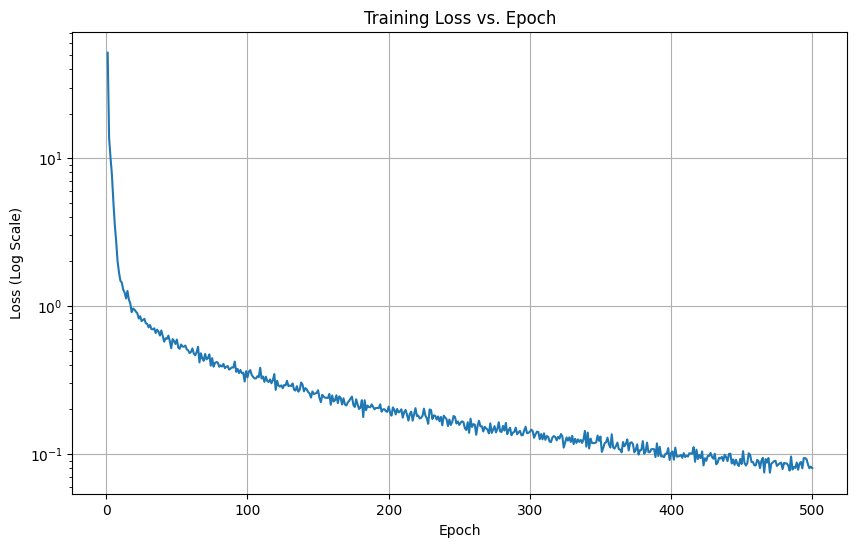

In [24]:
# need to get average loss per epoch
epoch_loss = np.zeros(num_epochs)  # Create an empty array of size num_epochs
for i in range(num_epochs):
    epoch_loss[i] = np.mean(loss_history[i * 80 : (i + 1) * 80])

plt.figure(figsize=(10, 6))
plt.semilogy(range(1, num_epochs + 1), epoch_loss)  # Use semilogy for log scale on y-axis
plt.xlabel('Epoch')
plt.ylabel('Loss (Log Scale)')
plt.title('Training Loss vs. Epoch')
plt.grid(True)
plt.show()

branch_input_test shape: torch.Size([100, 50])
trunk_input_test shape: torch.Size([100, 1])


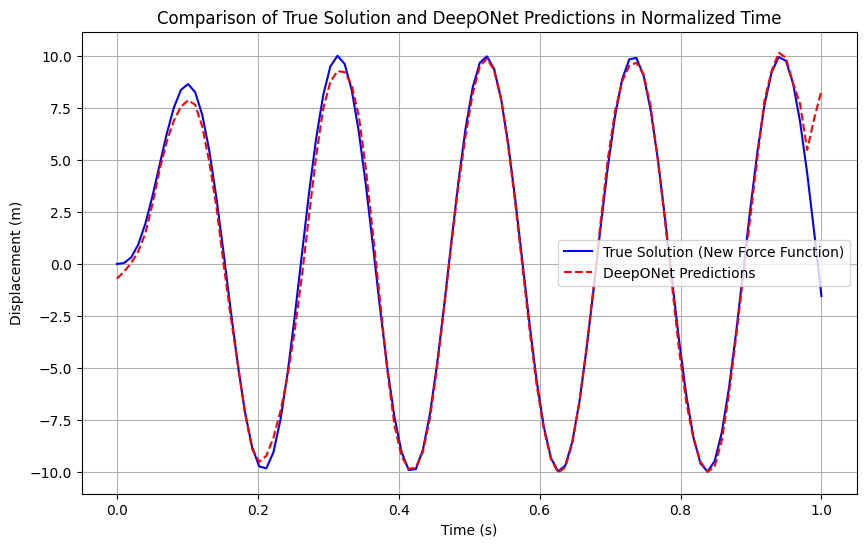

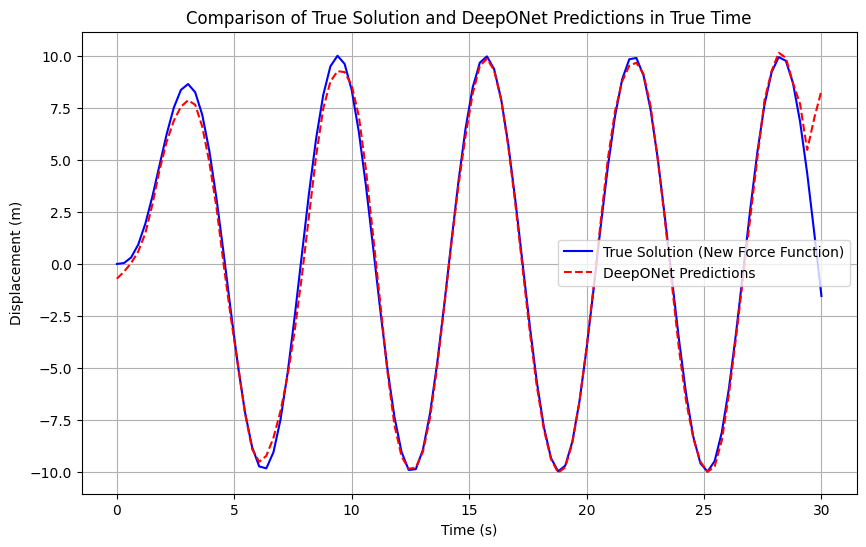

In [37]:
# Define a new force function (not used in training)
def new_force_function(t, amplitude=5.0, period=1.0, phase_shift=0.0, vertical_shift=0.0):
    return amplitude * np.sin(period * (t + phase_shift)) + vertical_shift

# Set the parameters for the new force function
parameters['amplitude'] = 5.0
parameters['period'] = 1.0
parameters['phase_shift'] = 0.0
parameters['vertical_shift'] = 0.0

# Generate normalized uniform sensor locations
num_sensors = 100
sensor_min = 0.0
sensor_max = 1.0
sensor_locations = np.linspace(sensor_min, sensor_max, num_sensors)

# Generate data for the new force function
t_test, y_test = spring_mass_damper_with_force(t_span, initial_conditions, parameters, new_force_function)
t_new_force = np.linspace(t_span[0], t_span[1], num_input_function_points)
new_force_values = external_force(t_new_force, amplitude)

# Extract displacement (u) at sensor locations for all time steps in 't'
cubic_spline = CubicSpline(t, z[0])  # Using displacement (z[0]) as the dependent variable
sensor_times = sensor_locations * (t_span[1] - t_span[0]) + t_span[0]  # Convert sensor locations to time values
displacements_at_sensors = cubic_spline(sensor_times)

# Prepare the inputs for the DeepONet
branch_input_test = torch.tensor([new_force_values] * len(displacements_at_sensors), dtype=torch.float32).to(device)  # Initial conditions
trunk_input_test = torch.tensor(sensor_locations, dtype=torch.float32).unsqueeze(-1).to(device)  # Sensor locations
print(f"branch_input_test shape: {branch_input_test.shape}")
print(f"trunk_input_test shape: {trunk_input_test.shape}")

# Make predictions using the trained DeepONet model
with torch.no_grad():  # No need to calculate gradients during inference
    deeponet_predictions = deepo_net(branch_input_test, trunk_input_test)

# Plot the results in normalized time
plt.figure(figsize=(10, 6))
plt.plot(sensor_locations, displacements_at_sensors, label='True Solution (New Force Function)', color='blue')  # True solution
plt.plot(sensor_locations, deeponet_predictions.squeeze().cpu().numpy(), label='DeepONet Predictions', color='red', linestyle='--')  # DeepONet predictions

plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Comparison of True Solution and DeepONet Predictions in Normalized Time')
plt.legend()
plt.grid()
plt.show()

# Plot the results in true time
plt.figure(figsize=(10, 6))
plt.plot(sensor_locations*t_span[-1], displacements_at_sensors, label='True Solution (New Force Function)', color='blue')  # True solution
plt.plot(sensor_locations*t_span[-1], deeponet_predictions.squeeze().cpu().numpy(), label='DeepONet Predictions', color='red', linestyle='--')  # DeepONet predictions

plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Comparison of True Solution and DeepONet Predictions in True Time')
plt.legend()
plt.grid()
plt.show()

In [35]:
print(f'sensor_locations: {sensor_locations}')
print(f'displacements_at_sensors: {displacements_at_sensors}')
print(f'deeponet_predictions: {deeponet_predictions}')

sensor_locations: [0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 